In [1]:
%load_ext autoreload
%autoreload 2
import torch

import os
from os import path
import sys
cwd = os.getcwd().split(os.path.sep)

# point to the git repository
while cwd[-1] != "AttentionGeometry":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
print(f">> current directory : {os.getcwd()}")

# add the root directory
sys.path.append(os.path.join(os.getcwd(), "src"))

# cache and data cache
cache_path = path.join(os.getcwd() ,'.cache_bert')
dataset_path = path.join(cache_path, 'dataset')
log_path = path.join(cache_path, 'logs')
model_path = path.join(cache_path, 'models')
print(f">> cache path : {cache_path}")
print(f">> model path : {model_path}")
print(f">> dataset path : {dataset_path}")
print(f">> logs path : {log_path}")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

>> current directory : c:\Users\loicf\Documents\IRISA\AttentionGeometry
>> cache path : c:\Users\loicf\Documents\IRISA\AttentionGeometry\.cache_bert
>> model path : c:\Users\loicf\Documents\IRISA\AttentionGeometry\.cache_bert\models
>> dataset path : c:\Users\loicf\Documents\IRISA\AttentionGeometry\.cache_bert\dataset
>> logs path : c:\Users\loicf\Documents\IRISA\AttentionGeometry\.cache_bert\logs


In [2]:
from datasets import load_dataset
dataset = load_dataset("imdb", split='test')

Reusing dataset imdb (C:\Users\loicf\.cache\huggingface\datasets\imdb\plain_text\1.0.0\2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


In [3]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [4]:
def tokenize_function(data):
  return tokenizer(data["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Loading cached processed dataset at C:\Users\loicf\.cache\huggingface\datasets\imdb\plain_text\1.0.0\2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1\cache-1c7924b1003b33f4.arrow


In [5]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(
    os.path.join(log_path, "imdb", "imdb-ft-3"),
    num_labels=2,
    output_hidden_states=True
)
model = model.eval()
model = model.to(DEVICE)

In [6]:
# get the r_i
import numpy as np
class_1 = 0
r_0 = None
for i in range(len(tokenized_datasets)):
    ex = tokenized_datasets[i]
    label = tokenized_datasets[i]["label"]
    ids = torch.tensor(ex["input_ids"]).unsqueeze(0)
    att_mask = attention_mask=torch.tensor(ex["attention_mask"]).unsqueeze(0)
    output_model = model(
        input_ids = ids.to(DEVICE), 
        attention_mask = att_mask.to(DEVICE)
    )
    pred = output_model.logits
    if label == class_1 and np.argmax(pred.detach().cpu().numpy()) == label:
        print( np.argmax(pred.detach().cpu().numpy()))
        print(label)
        r_0 = output_model.hidden_states[-1][0, 0, :]
        print("pred found")
        break

0
0
pred found


In [7]:
cos_res = []
legend = []
ds = tokenized_datasets
from tqdm.notebook import tqdm
with torch.no_grad():
    for i in tqdm(range(len(tokenized_datasets)), total=25000):

        ex = ds[i]
        label = ex["label"]
        ids = torch.tensor(ex["input_ids"]).unsqueeze(0)
        att_mask = attention_mask=torch.tensor(ex["attention_mask"]).unsqueeze(0)

        output_model = model(
            input_ids = ids.to(DEVICE), 
            attention_mask = att_mask.to(DEVICE),
        )

        temp = output_model.hidden_states[-1][0, 0, :]
        scalar = torch.dot(r_0, temp)
        cos_res.append((scalar / (torch.norm(temp) * torch.norm(r_0))).item())
        legend.append(label)

        """if i > 1000:
            break"""


    

  0%|          | 0/25000 [00:00<?, ?it/s]

In [8]:
set(legend)

{0, 1}

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


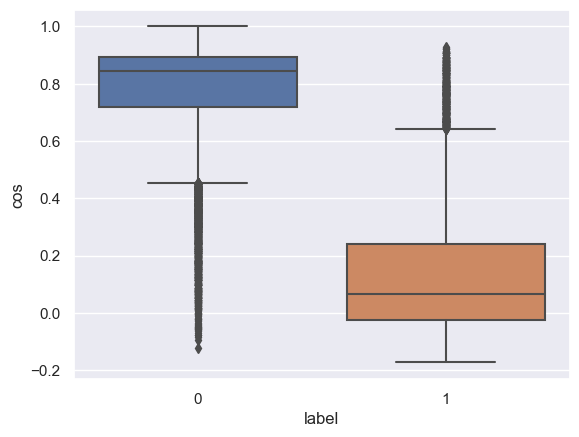

In [11]:
df = pd.DataFrame({
    "cos": cos_res,
    "label":legend
})

sns.boxplot(data=df, x = "label", y="cos")
plt.savefig(".cache_bert/plots/paper/imbd_cos_class.png")